# APOGEE Effective Selection Function Tutorial

Welcome to Tutorial 2 of how to use the APOGEE Selection Function! This jupyter notebook will walk you through the basic usage of the APOGEE Effective (3D) Selection Function using the pre-computed raw selection function for DR17.

More detail can be found here: https://github.com/astrojimig/precalculated-dr17-selfunc

If you have any questions, please email me at jimig@nmsu.edu

In [1]:
import numpy as np
import astropy.io.ascii as apascii
import matplotlib.pyplot as plt
import os
import time
import sys
import dill as pickle


#Environment variables
os.environ['RESULTS_VERS'] = 'dr17' #DR17
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/julieimig/research/APOGEE/'
os.environ['DUST_DIR'] = '/Users/julieimig/research/APOGEE/python_packages/dustmaps/'
apogeepath='/Users/julieimig/research/APOGEE/sandbox/apogee/' 
mwdustpath = '/Users/julieimig/research/APOGEE/python_packages/mwdust/'
galpypath = '/Users/julieimig/research/APOGEE/python_packages/galpy/'

sys.path.insert(1, apogeepath)
sys.path.insert(1, mwdustpath)
sys.path.insert(1, galpypath)


import apogee.select as apsel
import mwdust


/Users/julieimig/anaconda3/lib/python3.6/site-packages/galpy-1.7.0.dev0-py3.6.egg/galpy/util/bovy_plot.py:5: FutureWarning: galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9
  warnings.warn('galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9',FutureWarning)

/Users/julieimig/anaconda3/lib/python3.6/site-packages/galpy-1.7.0.dev0-py3.6.egg/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the ol

In [2]:
#Plotting Parameters
params = {'axes.labelsize': 36, 'xtick.labelsize': 36, 'ytick.labelsize': 36, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 22, 'font.family': 'serif', 'font.size': 36}
plt.rcParams.update(params)


# Load in Raw Selection Function

In [3]:
#Load in Raw Selection Function
with open('sav/apogeeCombinedSF.dat', 'rb') as f:
    apo = pickle.load(f)

# Define your Dustmap
In this case, I use the Combined19 dustmap from [mwdust](https://github.com/jobovy/mwdust), Which is a comibination of [Green 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...887...93G/abstract), [Marshall 2006](https://ui.adsabs.harvard.edu/abs/2006A%26A...453..635M/abstract) and [Drimmel 2003](https://ui.adsabs.harvard.edu/abs/2003A%26A...409..205D/abstract) dust maps

In [4]:
dmap = mwdust.Combined19()

# Define a Save Name
This name will be used to save out your selection function.

In [5]:
savename = 'apogee_effsel_example'

# Define Distance bins
For each APOGEE location, the effective selection function will be calculated along line of sight for a number of distance bins.

In [6]:
#number of distance bins
ndistmods=100 

#Distances to sample (in kpc)
ds = np.linspace(0.01,25.0,ndistmods) 

# Load in isochrone
The isochrone is used in the selection function to approximate the intrinsic distribution of stars in color-magnitude space. Because this depends on parameters like age and metallicity, a separate effective selection function should be calculated for each stellar population you want to study! 


In [7]:
#Load in Isochrones
#The included isochrones come from http://stev.oapd.inaf.it/cgi-bin/cmd
#Change as needed to accomodate your science!
JHK_iso = apascii.read('isochroes_HJK_log.dat')

target_metallicity = 0.0
target_age = 9.60001

isochrone_mask = (JHK_iso['logAge'] == target_age)&(JHK_iso['MH'] == target_metallicity)&(JHK_iso['label']<=8)

JHK_iso = JHK_iso[isochrone_mask]

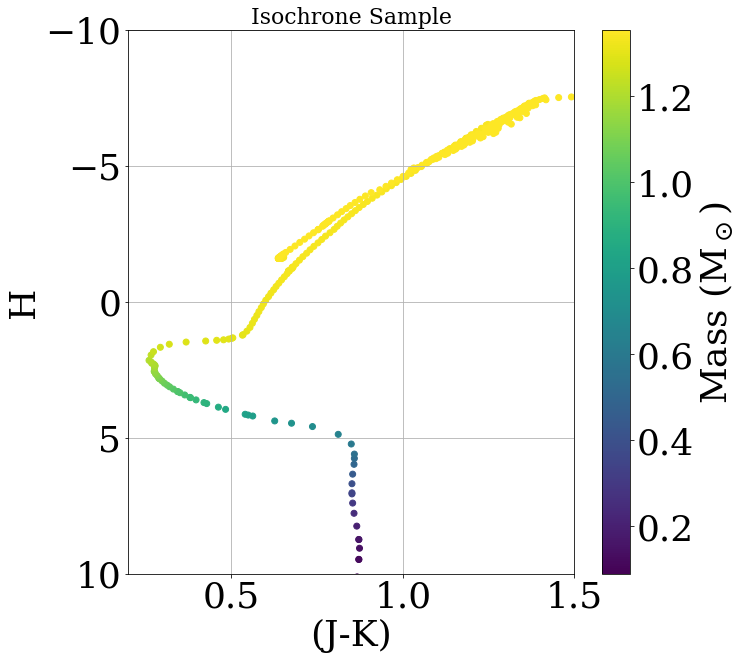

In [8]:
# Plot the isochrone!
plt.figure(figsize=(10,10))
plt.scatter(JHK_iso['Jmag']-JHK_iso['Ksmag'],JHK_iso['Hmag'],c=JHK_iso['Mini'])
plt.ylim(10,-10)
plt.xlim(0.2,1.5)
plt.xlabel('(J-K)')
plt.ylabel('H')
plt.title('Isochrone Sample')
plt.colorbar(label='Mass (M$_\odot$)')
plt.grid()

plt.show()

# Some Minor Calculations
If you defined everything above, you do not need to do anything additional in this cell!

In [9]:
#Convert from distance in kpc to distance modulus
distmods=5.0*np.log10(ds*1000)-5.0
minmax_distmods = [np.min(distmods),np.max(distmods)]

# More Minor Calculations - the isochrone "weights"

In the calculation of the effective selection function, each point of the isochrone needs to be weighted by how common it is in a single population of stars (i.e., low mass stars will be more common than high mass stars), based on some assumed IMF. For the PARSEC isochrones, this is baked into the "int_IMF" column with just some minor additional calculations needed. The cell below will work fine with the PARSEC isochrones, but may need some additional edits if you're using a different set.

Explaining what the "int_IMF" column is better than I can:

> FLUM has been replaced by int_IMF, which is the integral of the IMF under consideration (as selected in the form, in number of stars, and normalised to a total mass of 1 M☉) from 0 up to the current M_ini. **Differences between 2 values of int_IMF give the absolute number of stars occupying that isochrone section per unit mass of stellar population initially born, as expected for the selected IMF.** (http://stev.oapd.inaf.it/cmd_3.6/help.html)


In [10]:
def add_deltaM_column(iso):
    '''Adds a deltaM column to the isochrones'''
    deltaM = []
    for i in range(len(iso['MH'])):
        if (iso['MH'][i-1]==iso['MH'][i])&(iso['logAge'][i-1]==iso['logAge'][i])==True:
            deltaM.append(iso['int_IMF'][i]-iso['int_IMF'][i-1])
        else:
            deltaM.append(iso['int_IMF'][i+1]-iso['int_IMF'][i])
            
    return np.array(deltaM)

deltaMs = add_deltaM_column(JHK_iso)

# Initiate the Effective Selection Function Object
This will use everything set up previously: the raw selection function, the dustmap, and the isochrone points!

In [11]:
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap, 
MH=JHK_iso['Hmag'], JK0 = JHK_iso['Jmag']-JHK_iso['Ksmag'],
    weights = deltaMs)

# Calculating the Effective Selection Function

In [12]:
def progressbar(i,i_max):
    '''Makes a little progess bar'''
    percent_complete = int((i+1)/i_max*50)
    time_passed = time.time() - start_time
    progressbar = '[=' + '='*percent_complete + ' '*(50-percent_complete) + ']'
    est_time = (time_passed/(i+1))*len(apo._locations)
    progressbar+= ' {}% | Computing {}/{} | '.format(percent_complete,i+1,len(apo._locations))
    if est_time <= 60:
        est_time = str(int(est_time))+'s'
    else:
        est_time = str(int(est_time/60))+'m '+str(int(est_time%60))+'s'
        
    if time_passed <= 60:
        time_passed = str(int(time_passed))+'s'
    else:
        time_passed = str(int(time_passed/60))+'m '+str(int(time_passed%60))+'s'
        
    if i>0:
        progressbar+= 'Time Elapsed: {} Est. Time Remaining: {}               '.format(time_passed,est_time)
    return progressbar

In [14]:
m = deltaMs>0
H,J,K = JHK_iso['Hmag'][m],JHK_iso['Jmag'][m],JHK_iso['Ksmag'][m]
weights = deltaMs[m]/np.sum(deltaMs[m])

effsel_array = np.zeros((len(apo._locations),ndistmods))
start_time = time.time()

#Loop Through All Locations
for i in range(len(apo._locations)):
    sys.stdout.write(progressbar(i,len(apo._locations)) + '\r') #progressbar
    #Compute the Selection Function
    loc = apo._locations[i]
    jkmin = apo.JKmin(loc)
    try:
        effsel = apof.__call__(loc, ds, MH=H, JK0=(J-K), weights=weights)#*apo.area(loc)
    except: #there are 14 problem fields which crash the code! Working on a fix soon.
        effsel = np.ones(len(ds))*np.nan
    effsel_array[i] = effsel

np.savez(savename+'.npz', np.array(effsel_array))

/Users/julieimig/research/APOGEE/sandbox/apogee/apogee/select/apogeeSelect.py:2637: UserWarning: Different designs for this field have different radii; returning the first of these...
  warnings.warn("Different designs for this field have different radii; returning the first of these...")



# That's the basics of the effective selection function!

At the end, the product is a (N x M) array where N is the number of locations in the APOGEE raw selection function and M is the distance grid selected. Depending on your science case, you may need to compute a separate effective selection function for a variety of different combinations of metallicity and age. You can (and probably should) parallelize this to decrease computing time!


# Plot the Effective Selection Function

In [15]:
#For calculating coordinates...
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import Galactocentric

/Users/julieimig/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  



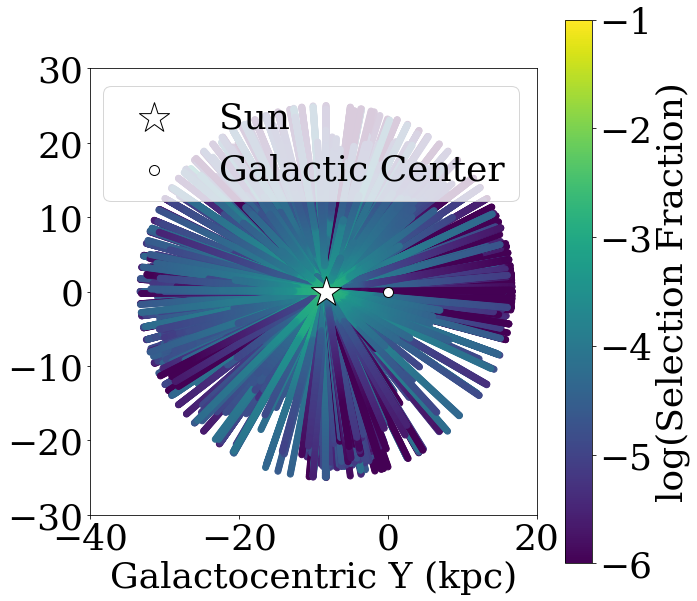

In [16]:
plt.figure(figsize=(10,10))
ax= plt.subplot(111)
#for i in range(len(effsel_array)):
for i in range(len(apo._locations)):
    c = coord.SkyCoord(l=np.ones(len(ds))*aposel_glons[i]*u.degree, b=np.ones(len(ds))*aposel_glats[i]*u.degree, 
                   distance=ds*u.kpc, frame='galactic')    
    c = c.transform_to(coord.Galactocentric)
    im = plt.scatter(c.x,c.y,c=np.log10(effsel_array[i]),vmin=-6,vmax=-1)
    
    
plt.scatter(-8.3, 0, marker='*',facecolor='white', edgecolor='k', s=1000,label='Sun')
plt.scatter(0, 0, marker='o',facecolor='white', edgecolor='k',s=100,label='Galactic Center')
plt.legend()
plt.xlabel('Galactocentric X (kpc)')
plt.xlabel('Galactocentric Y (kpc)')
plt.colorbar(im, label = 'log(Selection Fraction)')
plt.xlim(-40,20)
plt.ylim(-30,30)
ax.set_aspect('equal')

plt.show()